# Set Up and Getting Data Ready

In [1]:
import os
import s3fs
import math
import weave
import random
import matplotlib.pyplot as plt

from weave.pantry import Pantry
from mpl_toolkits import mplot3d
from weave.mongo_loader import MongoLoader
from weave.index.index_pandas import IndexPandas

In [2]:
# this is a function built in house (part of the weave library)
client = weave.config.get_mongo_db()

# create a pantry
# include mongo_client variable to upload mongo data
# this is a function built in house (part of the weave library)
demo_pantry_path = "mongodb-demo"
demo_pantry = weave.Pantry(
    weave.IndexPandas,
    pantry_path=demo_pantry_path,
    file_system=s3fs.S3FileSystem(client_kwargs = {'endpoint_url': os.environ['S3_ENDPOINT']}),
    mongo_client=client,
)

In [3]:
# generating some more interesting data
# The purpose of metadata is to store a snap shot of the entire dataset. In this trivial example there is the altitude, and speed for
# every second of a 2 hour flight. There is also a singular data point of how much fuel was burned. A big purpose of using pymongo is 
# to store some interesting data points about the data so there is a quick snapshot of the whole dataset. Faster to query singular
# data points such as max_altitude to know more about a particular dataset rather than looking at every altitude data point.
max_altitude = 8_000
for i in range(0,25):
    max_speed = math.floor(900 * random.uniform(1, 2.1))
    fuel_burned = math.floor(max_speed * random.uniform(4.5, 5.2) + random.uniform(-150, 250))
    demo_pantry.upload_basket(
        upload_items=[{'path': '/home/jovyan/opal/resources/652200104150842.ch10', 'stub': True}],
        basket_type='ch10',
        metadata = {'ch10name': '652200104150842', 'max_altitude': max_altitude, 'max_speed': max_speed, 'fuel_burned': fuel_burned},
    )
    max_altitude += 350

In [4]:
# ensure the index is up to date
# updates the json files in the index folder in the bucket
index = demo_pantry.index
index.generate_index()

# get the pandas df representation.
index_df = index.to_pandas_df()
index_df.head()

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
0,a6d713cc56c211f0bee30242ac19000b,2025-07-01 21:30:47.145143+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/a6d713cc56c211f0bee30242ac19...,S3FileSystem
1,a718bb1056c211f0bee30242ac19000b,2025-07-01 21:30:47.568976+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/a718bb1056c211f0bee30242ac19...,S3FileSystem
2,a74ac5ec56c211f0bee30242ac19000b,2025-07-01 21:30:47.892626+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/a74ac5ec56c211f0bee30242ac19...,S3FileSystem
3,a77a5d7a56c211f0bee30242ac19000b,2025-07-01 21:30:48.207460+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/a77a5d7a56c211f0bee30242ac19...,S3FileSystem
4,a7b9d31a56c211f0bee30242ac19000b,2025-07-01 21:30:48.622041+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/a7b9d31a56c211f0bee30242ac19...,S3FileSystem


In [5]:
print(f"Index length: {len(index)}")
# basket_type is a pandas function
# https://pandas.pydata.org/docs/reference/api/pandas.Series.html
# basket is a Series attribute
index_df.basket_type.value_counts()

Index length: 25


basket_type
ch10    25
Name: count, dtype: int64

# MongoDB Tutorial

In [6]:
# initalizing a mongo database for the demo pantry
# this is a function built in house (part of the weave library)
# https://github.com/309thEDDGE/weave/blob/main/weave/mongo_loader.py
# above is where most of the functions built in house for mongo is
mongo = MongoLoader(pantry=demo_pantry, mongo_client=client)

In [7]:
# printing the database name
print(mongo.database_name)

# setting a variable for the mongo database
mongodb = mongo.database
print(mongodb)

mongodb-demo
Database(MongoClient(host=['mongodb:27017'], document_class=dict, tz_aware=False, connect=True, timeoutms=0.0), 'mongodb-demo')


In [8]:
# this is not an extensive pymongo tutorial just a small introduction
# getting collection names (similar to table names in a relational database)
# list_collection_names() is a pymongo function
collection_names = mongodb.list_collection_names()
for name in collection_names:
    print(name)

supplement
manifest
metadata


In [9]:
# getting each collection its own variable
# mongo.xxx_collection is part of the weave functionality
manifest_collection = mongodb[mongo.manifest_collection]
print(manifest_collection)
print(manifest_collection.count_documents({}))

metadata_collection = mongodb[mongo.metadata_collection]
print(metadata_collection)
print(metadata_collection.count_documents({}))

supplement_collection = mongodb[mongo.supplement_collection]
print(supplement_collection)
print(supplement_collection.count_documents({}))

Collection(Database(MongoClient(host=['mongodb:27017'], document_class=dict, tz_aware=False, connect=True, timeoutms=0.0), 'mongodb-demo'), 'manifest')
25
Collection(Database(MongoClient(host=['mongodb:27017'], document_class=dict, tz_aware=False, connect=True, timeoutms=0.0), 'mongodb-demo'), 'metadata')
25
Collection(Database(MongoClient(host=['mongodb:27017'], document_class=dict, tz_aware=False, connect=True, timeoutms=0.0), 'mongodb-demo'), 'supplement')
25


In [10]:
# the rest of these functions used in this notebook are standard pymongo functions
# getting the unique fieldnames (keys) for a collection 
def get_unique_fieldnames(collection):
    fieldnames = set()
    for doc in collection.find():
        def extract_keys(d, prefix=''):
            for k, v in d.items():
                full_key = f"{prefix}.{k}" if prefix else k
                fieldnames.add(full_key)
                if isinstance(v, dict):
                    extract_keys(v, full_key)
                elif isinstance(v, list):
                    for item in v:
                        if isinstance(item, dict):
                            extract_keys(item, full_key)
        extract_keys(doc)
    return fieldnames

# getting field names for each collection
manifest_fn = get_unique_fieldnames(manifest_collection)
metadata_fn = get_unique_fieldnames(metadata_collection)
supplement_fn = get_unique_fieldnames(supplement_collection)

print("Manifest fieldnames:", manifest_fn, "\n")
print("Metadata fieldnames: ", metadata_fn, "\n")
print("Supplement fieldnames: ", supplement_fn, "\n")

Manifest fieldnames: {'weave_version', 'upload_time', 'parent_uuids', '_id', 'label', 'basket_type', 'uuid'} 

Metadata fieldnames:  {'max_speed', 'fuel_burned', '_id', 'max_altitude', 'ch10name', 'basket_type', 'uuid'} 

Supplement fieldnames:  {'integrity_data.file_size', 'integrity_data.access_date', 'upload_items', 'upload_items.stub', 'integrity_data.source_path', 'integrity_data.byte_count', '_id', 'integrity_data.upload_path', 'integrity_data', 'integrity_data.stub', 'upload_items.path', 'integrity_data.hash', 'basket_type', 'uuid'} 



In [11]:
# printing out the first 3 items in the metadata collection
print(list(metadata_collection.find({}))[0:3])
print(metadata_collection.count_documents({}))

[{'_id': ObjectId('6864538725e2fb1b531e4dd9'), 'uuid': 'a6d713cc56c211f0bee30242ac19000b', 'basket_type': 'ch10', 'ch10name': '652200104150842', 'max_altitude': 8000, 'max_speed': 1431, 'fuel_burned': 7182}, {'_id': ObjectId('6864538725e2fb1b531e4ddc'), 'uuid': 'a718bb1056c211f0bee30242ac19000b', 'basket_type': 'ch10', 'ch10name': '652200104150842', 'max_altitude': 8350, 'max_speed': 1161, 'fuel_burned': 5833}, {'_id': ObjectId('6864538825e2fb1b531e4ddf'), 'uuid': 'a74ac5ec56c211f0bee30242ac19000b', 'basket_type': 'ch10', 'ch10name': '652200104150842', 'max_altitude': 8700, 'max_speed': 1836, 'fuel_burned': 9329}]
25


In [12]:
# printing out the first 3 items in the manifest collection
print(list(manifest_collection.find({}))[0:3])
print(manifest_collection.count_documents({}))

[{'_id': ObjectId('6864538725e2fb1b531e4dda'), 'uuid': 'a6d713cc56c211f0bee30242ac19000b', 'upload_time': '2025-07-01T21:30:47.145143+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.13.2'}, {'_id': ObjectId('6864538725e2fb1b531e4ddd'), 'uuid': 'a718bb1056c211f0bee30242ac19000b', 'upload_time': '2025-07-01T21:30:47.568976+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.13.2'}, {'_id': ObjectId('6864538825e2fb1b531e4de0'), 'uuid': 'a74ac5ec56c211f0bee30242ac19000b', 'upload_time': '2025-07-01T21:30:47.892626+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.13.2'}]
25


In [13]:
# printing out the first 3 items in the supplement collection
print(list(supplement_collection.find({}))[0:3])
print(supplement_collection.count_documents({}))

[{'_id': ObjectId('6864538725e2fb1b531e4ddb'), 'uuid': 'a6d713cc56c211f0bee30242ac19000b', 'basket_type': 'ch10', 'integrity_data': [{'file_size': 1024780, 'hash': '29b43ef8fe61d0077138f04b2570f6bc311255aa90ac6caedb07827ec2704c7c', 'access_date': '2025-07-01T21:30:47.145079+00:00', 'source_path': '/home/jovyan/opal/resources/652200104150842.ch10', 'byte_count': 100000000, 'stub': True, 'upload_path': 'stub'}], 'upload_items': [{'path': '/home/jovyan/opal/resources/652200104150842.ch10', 'stub': True}]}, {'_id': ObjectId('6864538725e2fb1b531e4dde'), 'uuid': 'a718bb1056c211f0bee30242ac19000b', 'basket_type': 'ch10', 'integrity_data': [{'file_size': 1024780, 'hash': '29b43ef8fe61d0077138f04b2570f6bc311255aa90ac6caedb07827ec2704c7c', 'access_date': '2025-07-01T21:30:47.568902+00:00', 'source_path': '/home/jovyan/opal/resources/652200104150842.ch10', 'byte_count': 100000000, 'stub': True, 'upload_path': 'stub'}], 'upload_items': [{'path': '/home/jovyan/opal/resources/652200104150842.ch10', 

In [14]:
# find one item with a basket_type of ch10 in the manifest collection
# this can be done better using weave indexing
ch10_find_one = manifest_collection.find_one({"basket_type": "ch10"})
print(ch10_find_one)

{'_id': ObjectId('6864538725e2fb1b531e4dda'), 'uuid': 'a6d713cc56c211f0bee30242ac19000b', 'upload_time': '2025-07-01T21:30:47.145143+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.13.2'}


In [15]:
# print all of the items that has a weave version of 1.13.2 in the manifest collection
# this can be done better using weave indexing
weave_ver_find = manifest_collection.find({"weave_version": "1.13.2"})
print(weave_ver_find)

for i in range(0, 5):
    print(weave_ver_find[i])
print("\n")

# different weave version not in data
weave_ver_find = manifest_collection.find({"weave_version": "589.13.4"})
print(weave_ver_find)

# nothing was printed because nothing with weave version 589.13.4
for single_item in weave_ver_find:
    print(single_item)

{'_id': ObjectId('6864538725e2fb1b531e4dda'), 'uuid': 'a6d713cc56c211f0bee30242ac19000b', 'upload_time': '2025-07-01T21:30:47.145143+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.13.2'}
{'_id': ObjectId('6864538725e2fb1b531e4ddd'), 'uuid': 'a718bb1056c211f0bee30242ac19000b', 'upload_time': '2025-07-01T21:30:47.568976+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.13.2'}
{'_id': ObjectId('6864538825e2fb1b531e4de0'), 'uuid': 'a74ac5ec56c211f0bee30242ac19000b', 'upload_time': '2025-07-01T21:30:47.892626+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.13.2'}
{'_id': ObjectId('6864538825e2fb1b531e4de3'), 'uuid': 'a77a5d7a56c211f0bee30242ac19000b', 'upload_time': '2025-07-01T21:30:48.207460+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.13.2'}
{'_id': ObjectId('6864538825e2fb1b531e4de6'), 'uuid': 'a7b9d31a56c211f0bee30242ac19000b', 'upload_time':

In [16]:
# getting uuid for each item in the manifest collection
all_uuids_find = manifest_collection.find({}, {'uuid': True})
print(all_uuids_find)
print(len(list(all_uuids_find.clone())))

for i in range(0, 5):
    print(all_uuids_find[i]['uuid'])

25
a6d713cc56c211f0bee30242ac19000b
a718bb1056c211f0bee30242ac19000b
a74ac5ec56c211f0bee30242ac19000b
a77a5d7a56c211f0bee30242ac19000b
a7b9d31a56c211f0bee30242ac19000b


In [17]:
# printing out all the uuids for each item in the manifest collection using the find() function in a different way
for i in range(0, 5):
    object_id = manifest_collection.find()[i]['uuid']
    print(object_id)

# can be done this way but do not want to print out all uuids
# for document in manifest_collection.find():
#     object_id = document['uuid']
#     print(object_id)

a6d713cc56c211f0bee30242ac19000b
a718bb1056c211f0bee30242ac19000b
a74ac5ec56c211f0bee30242ac19000b
a77a5d7a56c211f0bee30242ac19000b
a7b9d31a56c211f0bee30242ac19000b


In [18]:
# another example to get uuids by using the distinct function to get all uuids (trivial example to show some different functions,
# since all uuids are distinct)
manifest_ids = manifest_collection.distinct('uuid')
print(len(manifest_ids))
print(manifest_ids[0:10])

25
['a6d713cc56c211f0bee30242ac19000b', 'a718bb1056c211f0bee30242ac19000b', 'a74ac5ec56c211f0bee30242ac19000b', 'a77a5d7a56c211f0bee30242ac19000b', 'a7b9d31a56c211f0bee30242ac19000b', 'a7eed9f256c211f0bee30242ac19000b', 'a8237cac56c211f0bee30242ac19000b', 'a857267e56c211f0bee30242ac19000b', 'a885ae4a56c211f0bee30242ac19000b', 'a8c1a33256c211f0bee30242ac19000b']


# Less trival examples

In [19]:
# getting all documents' uuid's in metadata_collection that follows the query below
# max_altitude > 10_000
# max_speed < 1_450
# fuel_burned >= 6_000 and <= 8_000
query = {"max_altitude": {"$gt": 10_000}, "max_speed": {"$lt": 1_450}, "fuel_burned": {"$gte": 6_000, "$lte": 8_000}}

# querying data like this is the main purpose of using a mongo db
# put the data into its own bucket and use weave for getting parent uuids, seeing what files in the bucket, etc.
doc_uuids = list(metadata_collection.find(query))

print(f"There are {len(doc_uuids)} out of {metadata_collection.count_documents({})} documents that satisfy the above query")
print(f"Those documents' uuid's are \n{doc_uuids}")

There are 3 out of 25 documents that satisfy the above query
Those documents' uuid's are 
[{'_id': ObjectId('6864538b25e2fb1b531e4dfa'), 'uuid': 'a939dafa56c211f0bee30242ac19000b', 'basket_type': 'ch10', 'ch10name': '652200104150842', 'max_altitude': 11850, 'max_speed': 1434, 'fuel_burned': 6684}, {'_id': ObjectId('6864538c25e2fb1b531e4e03'), 'uuid': 'a9fd49b856c211f0bee30242ac19000b', 'basket_type': 'ch10', 'ch10name': '652200104150842', 'max_altitude': 12900, 'max_speed': 1424, 'fuel_burned': 7248}, {'_id': ObjectId('6864538f25e2fb1b531e4e15'), 'uuid': 'ab98588a56c211f0bee30242ac19000b', 'basket_type': 'ch10', 'ch10name': '652200104150842', 'max_altitude': 15000, 'max_speed': 1380, 'fuel_burned': 6378}]


In [20]:
# 25 documents have metadata (metadata was entered when it was uploaded to the basket)
# 2 documents do not have metadata
print(metadata_collection.count_documents({}))

25


In [21]:
# adding more data
# automatically gets uploaded to the mongodb
# with basket_type ch10_2 (ch10 for the previous time data was uploaded)
max_altitude = 8_000
for i in range(0,25):
    max_speed = math.floor(900 * random.uniform(1, 2.1))
    fuel_burned = math.floor(max_speed * random.uniform(4.5, 5.2) + random.uniform(-150, 250))
    demo_pantry.upload_basket(
        upload_items=[{'path': '/home/jovyan/opal/resources/652200104150842.ch10', 'stub': True}],
        basket_type='ch10_2',
        metadata = {'ch10name': '652200104150842', 'max_altitude': max_altitude, 'max_speed': max_speed, 'fuel_burned': fuel_burned},
    )
    max_altitude += 350

In [22]:
# the pandas df representation
index = demo_pantry.index
index_df = index.to_pandas_df()
index_df.head()

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
0,a6d713cc56c211f0bee30242ac19000b,2025-07-01 21:30:47.145143+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/a6d713cc56c211f0bee30242ac19...,S3FileSystem
1,a718bb1056c211f0bee30242ac19000b,2025-07-01 21:30:47.568976+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/a718bb1056c211f0bee30242ac19...,S3FileSystem
2,a74ac5ec56c211f0bee30242ac19000b,2025-07-01 21:30:47.892626+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/a74ac5ec56c211f0bee30242ac19...,S3FileSystem
3,a77a5d7a56c211f0bee30242ac19000b,2025-07-01 21:30:48.207460+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/a77a5d7a56c211f0bee30242ac19...,S3FileSystem
4,a7b9d31a56c211f0bee30242ac19000b,2025-07-01 21:30:48.622041+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/a7b9d31a56c211f0bee30242ac19...,S3FileSystem


In [23]:
# the 25 items are in minio as ch10_2 basket type
print(f"Index length: {len(index)}")
index_df.basket_type.value_counts()

Index length: 50


basket_type
ch10      25
ch10_2    25
Name: count, dtype: int64

In [24]:
# those 25 items uploaded to minio are also in the mongodb
# there are 50 documents that have a metadata collection
metadata_collection = mongodb[mongo.metadata_collection]
print(metadata_collection.count_documents({}))

50


In [25]:
# lets see how many documents satisfy the same query
# include uuid column exclude _id column (_id column gets automatically put into the list)
projection = {"uuid": 1, "_id": 0}
doc_uuids = list(metadata_collection.find(query, projection))

print(f"There are {len(doc_uuids)} out of {metadata_collection.count_documents({})} documents that satisfy the above query")
print(f"Those documents' uuid's are \n{doc_uuids}")

There are 5 out of 50 documents that satisfy the above query
Those documents' uuid's are 
[{'uuid': 'a939dafa56c211f0bee30242ac19000b'}, {'uuid': 'a9fd49b856c211f0bee30242ac19000b'}, {'uuid': 'ab98588a56c211f0bee30242ac19000b'}, {'uuid': 'b3ffebfa56c211f0bee30242ac19000b'}, {'uuid': 'b5bc668056c211f0bee30242ac19000b'}]


# Graph the Data

In [26]:
labels = []
max_speed_data = []
fuel_burned_data = []
max_altitude_data = []
# making the list of dictionaries just of list of uuids
doc_uuids = [d['uuid'] for d in doc_uuids]

# get data for the graph
for doc in metadata_collection.find():
    # if it satisfied the query from above then add True to label
    # this is so we can have those labels be a different color
    # from the rest
    if doc['uuid'] in doc_uuids:
        labels.append(True)
    else:
        labels.append(False)
    max_speed_data.append(doc['max_speed'])
    fuel_burned_data.append(doc['fuel_burned'])
    max_altitude_data.append(doc['max_altitude'])

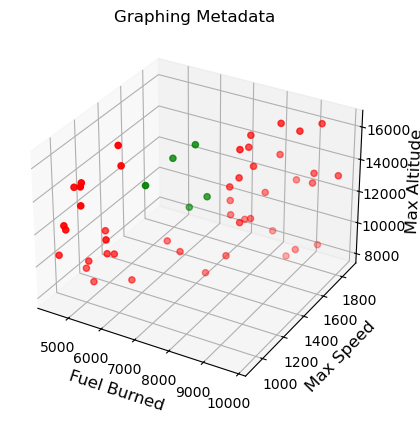

In [27]:
# create 3d axes
fig = plt.figure()
ax = plt.axes(projection='3d')
 
# data
x = fuel_burned_data
y = max_speed_data
z = max_altitude_data
colors = ['green' if label == True else 'red' for label in labels]
ax.scatter(x, y, z, c=colors)

ax.set_title('Graphing Metadata', fontsize=12)
ax.set_xlabel('Fuel Burned', fontsize=12)
ax.set_ylabel('Max Speed', fontsize=12)
ax.set_zlabel('Max Altitude', fontsize=12)
 
plt.show()

# Inserting More Data

In [28]:
# uploading baskets to the demo_pantry while note giving weave.Pantry a mongo_client
demo_pantry = weave.Pantry(
    weave.IndexPandas,
    pantry_path=demo_pantry_path,
    file_system=s3fs.S3FileSystem(client_kwargs = {'endpoint_url': os.environ['S3_ENDPOINT']}),
)

demo_index = demo_pantry.index

for i in range(0,5):
    demo_pantry.upload_basket(
        upload_items=[{'path': '/home/jovyan/opal/resources/652200104150842.ch10', 'stub': True}],
        basket_type='ex1',
        metadata = {'max_altitude': 8_000, 'max_speed': 1_250, 'fuel_burned': 5_000},
    )

In [29]:
# pandas df representation
# new items are recognized by the index and are at the bottom of the dataframe if displaying index_df
index = demo_pantry.index
index_df = demo_pantry.index.to_pandas_df()
len(index_df)

55

In [30]:
# will be at 50 since the new data was not uploaded to the mongo database because weave.Pantry was not given a mongo_client
metadata_collection = mongodb[mongo.metadata_collection]
print(metadata_collection.count_documents({}))

50


In [31]:
# the ex1 basket is in minio but not in mongo database because length is 55
print(f"Index length: {len(index)}")
index_df.basket_type.value_counts()

Index length: 55


basket_type
ch10      25
ch10_2    25
ex1        5
Name: count, dtype: int64

In [32]:
# getting the uuids from the newly created baskets
# the newly created baskets are all of basket type 'ex1'
# the line of code is just pandas df code (no weave or opal specific fucntions)
ex1_uuids = list((index_df.loc[index_df['basket_type']=='ex1', 'uuid']))
print(ex1_uuids)
print(len(ex1_uuids))

['b6f6fa4c56c211f0bee30242ac19000b', 'b86435c056c211f0bee30242ac19000b', 'b8963bba56c211f0bee30242ac19000b', 'b8bbfe8656c211f0bee30242ac19000b', 'b8f6cfb656c211f0bee30242ac19000b']
5


In [33]:
# uploading items to the mongo database manually (items' uuid to upload to mongo is required)
mongo.load_mongo(ex1_uuids)

In [34]:
# will be 55 since the documents were uploaded to the mongo database
metadata_collection = mongodb[mongo.metadata_collection]
print(metadata_collection.count_documents({}))

55


# Cleanup

In [35]:
# deleting the pantry
s3 = s3fs.S3FileSystem(client_kwargs = {'endpoint_url': os.environ['S3_ENDPOINT']})
if s3.exists(demo_pantry_path):
    s3.rm(f's3://{demo_pantry_path}', recursive = True)
s3.mkdir(demo_pantry_path)

In [36]:
# clearing mongo database
mongo.clear_mongo()